In [1]:
from Kaggle_Titanic_utls import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('.')

In [3]:
# Import data
data = pd.read_csv(path / "train.csv")

In [4]:
data.shape

(891, 12)

In [5]:
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
data['Survived'].sum()/len(data)

0.3838383838383838

In [8]:
#Fare funzione Alessandro

The classes are sufficiently balanced - it makes sense to consider accuracy as performance metrics.

Embarked only has 2 missing values out of 891 - we will get rid of them altogether.

In [9]:
#data.dropna(subset=['Embarked'], inplace=True)

In [10]:
labels = data[['Survived']]

data.drop(['Cabin', 'Ticket', 'PassengerId', 'Survived'], axis=1, inplace=True)

In [11]:
data.corr().style.background_gradient(cmap ='cool')\
        .set_properties(**{'font-size': '15px'}) 

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,-0.549500,0.096067,0.159651,0.216225,1.000000


There are no highly correlated features (maybe do feature extraction?).

We can extract the title of each passenger from the name **(which is most likely not useful in the prediction. We can check this though)**.

In [12]:
#title = data.Name.apply(lambda x:x.split(',')[1].split('.')[0].strip())

In [13]:
title = get_title(data)

In [14]:
title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
the Countess      1
Jonkheer          1
Don               1
Sir               1
Ms                1
Capt              1
Lady              1
Mme               1
Name: Name, dtype: int64

In [15]:
data['Title'] = title
data.drop('Name', axis=1, inplace=True)

In [16]:
labels.shape, data.shape

((891, 1), (891, 8))

In [17]:
data.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title'], dtype='object')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Preprocessing

In [18]:
data_num, data_cat = get_features_by_type(data)

In [19]:
data_num

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500
...,...,...,...,...,...
886,2,27.0,0,0,13.0000
887,1,19.0,0,0,30.0000
888,3,NaN,1,2,23.4500
889,1,26.0,0,0,30.0000


In [20]:
data_, value_num, value_cat = preprocessing(data_num, data_cat)

In [21]:
value_num, value_cat

(Pclass     3.0000
 Age       28.0000
 SibSp      0.0000
 Parch      0.0000
 Fare      14.4542
 dtype: float64,
     Sex Embarked Title
 0  male        S    Mr)

data_num.fillna(data_num.median(), inplace=True)
data_cat.fillna(data_cat.mode(), inplace=True)

scaler = StandardScaler()

data_num_scaled = scaler.fit_transform(data_num)

data_cat_dummy = pd.get_dummies(data_cat)

data_ = np.c_[data_num_scaled, data_cat_dummy]

X_train, X_test, y_train, y_test = train_test_split(data_, labels,
                            random_state=1, test_size=0.25, stratify=labels)

## Baseline models

We look at various baseline models to check which ones give the best score in and out of sample

In [22]:
data_

,0,1,2,3,4,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.181487,-0.474545,-0.473674,-0.386671,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
887,-1.566107,-0.796286,-0.474545,-0.473674,-0.044381,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
888,0.827377,-0.104637,0.432793,2.008933,-0.176263,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
889,-1.566107,-0.258337,-0.474545,-0.473674,-0.044381,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
models = {'knn': KNeighborsClassifier(), 'LR': LogisticRegression(), 
         'tree': DecisionTreeClassifier(), 'GNB': GaussianNB(),
         'perceptron': Perceptron(), 'SVC': SVC()}

for i, j in models.items():
    scores = model_trial(data_, labels, j)
    print(color.BOLD + color.RED + color.UNDERLINE + f'{i} scores' + color.END + f': {scores}\n\n')

knn scores: {'train_score': 0.875748502994012, 'test_score': 0.8071748878923767}


LR scores: {'train_score': 0.8308383233532934, 'test_score': 0.820627802690583}


tree scores: {'train_score': 0.9865269461077845, 'test_score': 0.7802690582959642}


GNB scores: {'train_score': 0.7694610778443114, 'test_score': 0.7443946188340808}


perceptron scores: {'train_score': 0.7754491017964071, 'test_score': 0.8026905829596412}


SVC scores: {'train_score': 0.844311377245509, 'test_score': 0.8295964125560538}




Perceptron and Naive Bayes have a poor accuracy, whereas Decision Trees are clearly overfitting to the training set. SVC, Logistic Regression and KNN perform reasonably well in and out of sample (random guess would yield around $62 \%$ accuracy).

## Various imputations

We can also look at the impact that different imputation strategies bear on the accuracy of the models. In the following we have imputed missing values with mean, median and with zeros, and have assessed the effect of these on the three best performing models we have previously selected.

In [24]:
data_num, data_cat = get_features_by_type(data)

In [25]:
imputation_dict = {'median': data_num.median(), 'mean': data_num.mean(), 'zero': 0}

models = {'LR': LogisticRegression(), 'SVC': SVC(), 'knn': KNeighborsClassifier()}

for key, value in imputation_dict.items():
    data_, value_num, value_cat = preprocessing(data_num, data_cat, imputer_num=key)
    for k, v in models.items():
        scores = model_trial(data_, labels, model=v)
        print(color.BOLD + color.RED + color.UNDERLINE + f'{k, key} scores' + color.END + f': {scores}\n\n')

('LR', 'median') scores: {'train_score': 0.8308383233532934, 'test_score': 0.820627802690583}


('SVC', 'median') scores: {'train_score': 0.844311377245509, 'test_score': 0.8295964125560538}


('knn', 'median') scores: {'train_score': 0.875748502994012, 'test_score': 0.8071748878923767}


('LR', 'mean') scores: {'train_score': 0.8308383233532934, 'test_score': 0.820627802690583}


('SVC', 'mean') scores: {'train_score': 0.844311377245509, 'test_score': 0.8295964125560538}


('knn', 'mean') scores: {'train_score': 0.875748502994012, 'test_score': 0.8071748878923767}


('LR', 'zero') scores: {'train_score': 0.8308383233532934, 'test_score': 0.820627802690583}


('SVC', 'zero') scores: {'train_score': 0.844311377245509, 'test_score': 0.8295964125560538}


('knn', 'zero') scores: {'train_score': 0.875748502994012, 'test_score': 0.8071748878923767}




The imputation strategies considered bear no effect on the accuracy of any of the models. We will however keep the median as default imputation method as it is more robust than the mean and contains more information about the data than the zeros.

## Grid Search

We can now take the best models and preprocessing strategies and grid search the best parameters using cross validation.

### K-nearest Neighbors

In [26]:
data_num, data_cat = get_features_by_type(data)
data_, value_num, value_cat = preprocessing(data_num, data_cat)

In [27]:
param_grid = {'weights': ['uniform', 'distance'], 
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
               'n_neighbors': np.linspace(1, 15, 15).astype(int)}

In [28]:
gscv = GridSearchCV(models['knn'], cv=4, n_jobs=-3, param_grid=param_grid, scoring='accuracy', verbose=1)

In [29]:
%%time
gscv.fit(data_, labels)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    1.7s


CPU times: user 442 ms, sys: 360 ms, total: 802 ms
Wall time: 3.85 s


[Parallel(n_jobs=-3)]: Done 480 out of 480 | elapsed:    3.8s finished


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-3,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [30]:
gscv.best_estimator_, gscv.best_params_

(KNeighborsClassifier(algorithm='ball_tree', n_neighbors=12),
 {'algorithm': 'ball_tree', 'n_neighbors': 12, 'weights': 'uniform'})

In [31]:
best_est_knn = gscv.best_estimator_
best_est_knn.fit(data_, labels)
best_est_knn.score(data_, labels)

0.8372615039281706

### Logistic Regression

In [32]:
param_grid = [{'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 
                'C': np.logspace(-2, 2, 5, 10)},
               {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                'C': np.logspace(-2, 2, 5, 10)},
               {'penalty': ['elasticnet'], 'solver': ['saga'], 
                'l1_ratio': np.arange(0.1, 1, 0.1), 'C': np.logspace(-2, 2, 5, 10)},
                {'penalty': [None], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}]

In [33]:
gscv = GridSearchCV(models['LR'], cv=4, n_jobs=-3, param_grid=param_grid, scoring='accuracy', verbose=1)

In [34]:
%%time
gscv.fit(data_, labels)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-3)]: Done 100 tasks      | elapsed:    0.7s


CPU times: user 378 ms, sys: 72.3 ms, total: 451 ms
Wall time: 2.05 s


[Parallel(n_jobs=-3)]: Done 316 out of 316 | elapsed:    2.0s finished


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-3,
             param_grid=[{'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
                         {'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
                         {'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['elasticnet'], 'solver': ['saga']},
                         {'penalty': [None],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}],
             scoring='accuracy', verbose=1)

In [35]:
gscv.best_estimator_, gscv.best_params_

(LogisticRegression(l1_ratio=0.4, penalty='elasticnet', solver='saga'),
 {'C': 1.0, 'l1_ratio': 0.4, 'penalty': 'elasticnet', 'solver': 'saga'})

In [36]:
best_est_LR = gscv.best_estimator_
best_est_LR.fit(data_, labels)
best_est_LR.score(data_, labels)

0.8294051627384961

### SVC

In [37]:
param_grid = {'C': np.logspace(-2, 2, 5, 10),
               'kernel': ['linear', 'rbf', 'poly'],
              'degree': np.linspace(2, 5, 5).astype(int)}

In [38]:
gscv = GridSearchCV(models['SVC'], cv=4, n_jobs=-3, param_grid=param_grid, scoring='accuracy', verbose=1)

In [39]:
models['SVC'].get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [40]:
%%time
gscv.fit(data_, labels)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 4 folds for each of 75 candidates, totalling 300 fits


[Parallel(n_jobs=-3)]: Done 100 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-3)]: Done 289 out of 300 | elapsed:    3.7s remaining:    0.1s


CPU times: user 503 ms, sys: 36.1 ms, total: 539 ms
Wall time: 4.09 s


[Parallel(n_jobs=-3)]: Done 300 out of 300 | elapsed:    4.0s finished


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-3,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'degree': array([2, 2, 3, 4, 5]),
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [41]:
gscv.best_estimator_, gscv.best_params_

(SVC(degree=2, kernel='poly'), {'C': 1.0, 'degree': 2, 'kernel': 'poly'})

In [42]:
best_est_SVC = gscv.best_estimator_
best_est_SVC.fit(data_, labels)
best_est_SVC.score(data_, labels)

0.8395061728395061

Support Vector Classifier with a quadratic polynomial kernel and strength of the regularization equal to $C=1$ yields the best accuracy after grid-searching parameters. 

## Submission

In [43]:
test = pd.read_csv(path / 'test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [44]:
test_ids = test.PassengerId
test.drop(['Cabin', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [45]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,S
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,S


In [46]:
test_title = get_title(test)
test['Title'] = test_title
test.drop('Name', axis=1, inplace=True)

In [47]:
test_ = test_preprocessing(test, value_num, value_cat)

In [49]:
data_aligned, test_aligned = data_.align(test_, join='left', axis=1, fill_value=0)

In [50]:
test_aligned.shape

(418, 27)

In [55]:
test_predict_SVC = best_est_SVC.predict(test_aligned)
test_predict_LR = best_est_LR.predict(test_aligned)
test_predict_knn = best_est_knn.predict(test_aligned)

In [57]:
submission_SVC = np.c_[test_ids.values, test_predict_SVC]
submission_LR = np.c_[test_ids.values, test_predict_LR]
submission_knn = np.c_[test_ids.values, test_predict_knn]
pd.DataFrame(submission_SVC).to_csv(path / "submission_base_SVC.csv", header=['PassengerId', 'Survived'], index=False)
pd.DataFrame(submission_LR).to_csv(path / "submission_base_LR.csv", header=['PassengerId', 'Survived'], index=False)
pd.DataFrame(submission_knn).to_csv(path / "submission_base_knn.csv", header=['PassengerId', 'Survived'], index=False)

In [60]:
!kaggle competitions submit -c titanic -f "submission_base_SVC.csv" -m 'submission of base model'
!kaggle competitions submit -c titanic -f "submission_base_LR.csv" -m 'submission of base model'
!kaggle competitions submit -c titanic -f "submission_base_knn.csv" -m 'submission of base model'

100%|████████████████████████████████████████| 2.77k/2.77k [00:03<00:00, 793B/s]
100%|████████████████████████████████████████| 2.77k/2.77k [00:04<00:00, 700B/s]
100%|██████████████████████████████████████| 2.77k/2.77k [00:02<00:00, 1.03kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

## Some improvements

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7e5a22eb0>,
      dtype=object)

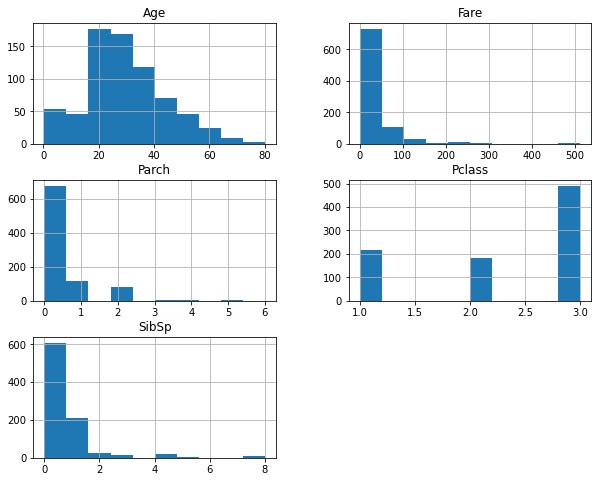

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))
data.hist(ax=ax)

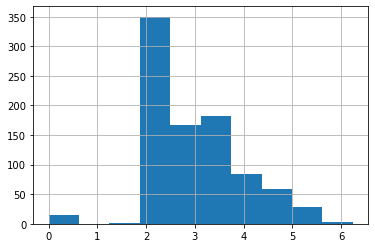

In [66]:
np.log1p(data.Fare).hist()

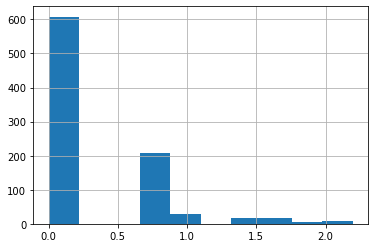

In [67]:
np.log1p(data.SibSp).hist()

# ================ Ignore the following ====================

## Imputation

In [18]:
selected_models = ['knn', 'log', 'svc'] 

imputation_methods = ['mean', 'median', 'function', 'zeros']

for i in selected_models:
    print(i)
    for j in imputation_methods:
        print('\t',j, base_pip(models[i], data, labels, imputer_s=j))
    print(' ')
        

knn
train_tr shape (755, 29)
	 mean (0.8609271523178808, 0.835820895522388)
train_tr shape (755, 29)
	 median (0.8649006622516556, 0.8582089552238806)
train_tr shape (755, 29)
	 function (0.8609271523178808, 0.8432835820895522)
train_tr shape (755, 29)
	 zeros (0.8582781456953642, 0.8432835820895522)
 
log
train_tr shape (755, 29)
	 mean (0.833112582781457, 0.8134328358208955)
train_tr shape (755, 29)
	 median (0.833112582781457, 0.8134328358208955)
train_tr shape (755, 29)
	 function (0.833112582781457, 0.8134328358208955)
train_tr shape (755, 29)
	 zeros (0.8304635761589404, 0.8134328358208955)
 
svc
train_tr shape (755, 29)
	 mean (0.8423841059602649, 0.8208955223880597)
train_tr shape (755, 29)
	 median (0.8423841059602649, 0.8208955223880597)
train_tr shape (755, 29)
	 function (0.8423841059602649, 0.8208955223880597)
train_tr shape (755, 29)
	 zeros (0.8397350993377484, 0.8208955223880597)
 


Different imputation methods have little impact on train and test for LR and SVC. KNN is slightly less stable from this standpoint, but it remains the best performing model, with the median as imputation method.

## Grid Search

Now that we have chosen our model, we can grid search parameters.

In [19]:
param_grid = {'weights': ['uniform', 'distance'], 
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
               'n_neighbors': np.linspace(1, 15, 15).astype(int)}

best_cv = base_pip(models['knn'], data, labels, 
                   imputer_s='median', option='grid_search', 
                   param_grid=param_grid, cv=3)

train_tr shape with gscv (889, 29)
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-3)]: Done 360 out of 360 | elapsed:    3.3s finished


In [20]:
models = {'best': best_cv['best_estimator']}


for i, j in models.items():
    print(i, base_pip(j, data, labels))

train_tr shape (755, 29)
best (0.8370860927152318, 0.8283582089552238)


## Submission

In [21]:
X_unknown = pd.read_csv(path / 'test.csv')
X_unknown.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
X_unknown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [23]:
X_unknown.dropna(subset=['Fare'], inplace=True)

In [24]:
X_unknown.drop(['Cabin', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [25]:
title_ = X_unknown.Name.apply(lambda x:x.split(',')[1].split('.')[0].strip())

X_unknown['Title'] = title

In [26]:
X_unknown.drop(['Name'], axis=1, inplace=True)

In [27]:
X_unknown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    417 non-null    int64  
 1   Sex       417 non-null    object 
 2   Age       331 non-null    float64
 3   SibSp     417 non-null    int64  
 4   Parch     417 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  417 non-null    object 
 7   Title     416 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 29.3+ KB


In [35]:
pipeline_wparams = best_cv['pipeline'].set_params(**best_cv['pipeline_params'])
X_unknown.dropna(subset=['Title'], inplace=True)
pipeline = best_cv['pipeline']
X_unknown_tr = pipeline.fit_transform(X_unknown)

In [33]:
X_train = pipeline.fit_transform(data)
X_train.shape

(889, 29)

In [32]:
X_unknown_tr = X_train.align(X_unknown_tr, axis=1)
X_unknown_tr

TypeError: unsupported type: <class 'numpy.ndarray'>

In [33]:
predictions = best_cv['best_estimator'].predict(X_unknown_tr)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 20 while Y.shape[1] == 28